<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Introduction to Data Preparation
    </h1></td>
    <td width="30%">
    <div style="text-align: right">
    <b> Practical Data Science Lessons</b><br><br>
    <b> Riccardo Bertoglio</b><br>
    <a href="mailto:riccardo.bertoglio@polimi.it">riccardo.bertoglio@polimi.it</a><br>
    </div>
</tr>
</table>

## Learning outcomes 🔎

*   [What is Data Preparation?](#what_is_data_prep)
*   [Missing values](#missing_values)
*   [Figure out why the data is missing](#why_missing)
*   [Dealing with missing values](#dealing)
*   [Drop missing values](#drop)
*   [Imputation](#imputation)
*   [Imputation with scikit-learn](#imputation_scikit)
*   [Missing indicators](#missing_indicators)
*   [Feature scaling](#scaling)
*   [Parsing dates](#parsing)
*   [Inconsistent data entry](#inconsistent_data_entry)

#### More difficult topics are marked with the climbing icon 🧗

#### Resources:
*   *[Kaggle Intermediate Machine Learning course](https://www.kaggle.com/learn/intermediate-machine-learning)*
*   *[Scikit-learn User Guide: Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)*
*   *[Normalization vs Standardization — Quantitative analysis](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)*

<a id='what_is_data_prep'></a>
## What is Data Preparation?
Data preparation is a key part of data science, but it can be deeply frustrating. Why are some of your text fields garbled? What should you do about those missing values? Why aren’t your dates formatted correctly? How can you quickly clean up inconsistent data entry? In this notebook, you'll learn how to fix these problems!

The [Anaconda 2022 State of Data Science Survey](https://www.anaconda.com/resources/whitepapers/state-of-data-science-report-2022) shows that data professionals spend a consistent part of their time preparing, cleaning, and visualizing the data!

<img src="https://www.anaconda.com/wp-content/uploads/2023/02/sjospxffwpllegouega.svg" alt="Drawing" style="width: 500px;"/>

## Setup the notebook

In [38]:
# modules we'll use
import pandas as pd
import numpy as np
import datetime

# for feature scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# helpful modules for data entry
import fuzzywuzzy
from fuzzywuzzy import process

# set seed for reproducibility
np.random.seed(0)

If you got `ModuleNotFoundError` errors, run the following lines of code

In [3]:
!pip install fuzzywuzzy

<a id='missing_values'></a>
## Missing values

### Take a first look at the data

The first thing we'll need to do is load in the libraries and dataset we'll be using. 

For demonstration, we'll use the [hepatitis dataset](https://datahub.io/machine-learning/hepatitis#readme). This dataset contains occurrences of hepatitis in people. Each entry of the dataset consists of a patient's health information and if they could survive the disease (`class` column). 

In [4]:
# read in all our data
hepatitis = pd.read_csv('data/hepatitis.csv')

# set seed for reproducibility
np.random.seed(0) 

The first thing to do when you get a new dataset is take a look at some of it. This lets you see that it all read in correctly and gives an idea of what's going on with the data. In this case, let's see if there are any missing values, which will be reprsented with `NaN` or `None`.

In [5]:
# look at the first five rows of the hepatitis dataset. 
# I can see a handful of missing data already!
hepatitis.head()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,200.0,4.0,NaN,False,live


Yep, it looks like there's some missing values. 

### How many missing data points do we have?

Ok, now we know that we do have some missing values. Let's see how many we have in each column. 

In [6]:
# get the number of missing data points per column
missing_values_count = hepatitis.isnull().sum()

# look at the n. of missing points in the first ten columns
missing_values_count[0:10]

age                 0
sex                 0
steroid             1
antivirals          0
fatigue             1
malaise             1
anorexia            1
liver_big          10
liver_firm         11
spleen_palpable     5
dtype: int64

That seems like a lot! It might be helpful to see what percentage of the values in our dataset were missing to give us a better sense of the scale of this problem:

In [7]:
# how many total missing values do we have?
total_cells = np.prod(hepatitis.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

5.387096774193548


A little more than 5% of the cells in this dataset are empty. It's not that much, but it is still worth trying to recover them! In the next step, we're going to take a closer look at some of the columns with missing values and try to figure out what might be going on with them.

<a id='why_missing'></a>
## Figure out why the data is missing
 
This is the point at which we get into the **part of data science that I like to call "data intution"**, by which I mean "really looking at your data and trying to figure out why it is the way it is and how that will affect your analysis". It can be a frustrating part of data science, especially if you're newer to the field and don't have a lot of experience. For dealing with missing values, you'll need to use your intution to figure out why the value is missing. One of the most important questions you can ask yourself to help figure this out is this:

> **Is this value missing because it wasn't recorded or because it doesn't exist?**

**If a value is missing because it doesn't exist (like the height of the oldest child of someone who doesn't have any children) then it doesn't make sense to try and guess what it might be. These values you probably do want to keep as `NaN`. On the other hand, if a value is missing because it wasn't recorded, then you can try to guess what it might have been based on the other values in that column and row**. This is called **imputation**, and we'll learn how to do it next! :)

Let's work through an example. Looking at our `hepatitis` dataframe, it is reasonable to think that missing values are so because they were not recorded. Indeed, features refer to health information that each person has. If you're doing very careful data analysis, this is the point at which you'd look at each column individually to figure out the best strategy for filling those missing values. It is importat to do so to avoid removing some useful information or adding some noise to your data. 

<a id='dealing'></a>
## Dealing with missing values


### 1) A Simple Option: Drop Columns (or Rows) with Missing Values

The simplest option is to drop columns (or rows) with missing values. 

![tut2_approach1](https://i.imgur.com/Sax80za.png)

**Unless most values in the dropped columns are missing**, the model loses access to a lot of (potentially useful!) information with this approach.  As an extreme example, consider a dataset with 10,000 rows, where one important column is missing a single entry. This approach would drop the column entirely!

Also, if you remove each row that contains a missing value you could end up dropping your entire dataset if every row in the dataset has at least one missing value.

### 2) A Better Option: Imputation

**Imputation** fills in the missing values with some number.  For instance, we can fill in the mean value along each column. 

![tut2_approach2](https://i.imgur.com/4BpnlPA.png)

The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.

### 3) Missing Indicators: An Extension To Imputation

Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, **your model would make better predictions by considering which values were originally missing**.  

![tut3_approach3](https://i.imgur.com/UWOyg4a.png)

In this approach, we impute the missing values, as before.  And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.

In some cases, this will meaningfully improve results. In other cases, it doesn't help at all.

<a id='drop'></a>
## Drop missing values

If you're in a hurry or don't have a reason to figure out why your values are missing, one option you have is to just remove any rows or columns that contain missing values. (Note: **I don't generally recommend this approch for important projects! It's usually worth it to take the time to go through your data and really look at all the columns with missing values one-by-one to really get to know your dataset.**)  

If you're sure you want to drop rows with missing values, pandas does have a handy function, `dropna()` to help you do this. Let's try it out on our hepatitis dataset!

In [8]:
# let's first print the dataset's number of rows
hepatitis.shape[0]

155

In [9]:
# remove all the rows that contain a missing value
hepatitis.dropna()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
5,34,female,True,False,False,False,False,True,False,False,False,False,False,0.9,95.0,28.0,4.0,75.0,False,live
10,39,female,False,True,False,False,False,False,True,False,False,False,False,1.3,78.0,30.0,4.4,85.0,False,live
11,32,female,True,True,True,False,False,True,True,False,True,False,False,1.0,59.0,249.0,3.7,54.0,False,live
12,41,female,True,True,True,False,False,True,True,False,False,False,False,0.9,81.0,60.0,3.9,52.0,False,live
13,30,female,True,False,True,False,False,True,True,False,False,False,False,2.2,57.0,144.0,4.9,78.0,False,live
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,45,female,True,True,False,False,False,True,False,False,False,False,False,1.3,85.0,44.0,4.2,85.0,True,live
143,49,female,False,False,True,True,False,True,False,True,True,False,False,1.4,85.0,70.0,3.5,35.0,True,die
145,31,female,False,False,True,False,False,True,False,False,False,False,False,1.2,75.0,173.0,4.2,54.0,True,live
153,53,male,False,False,True,False,False,True,False,True,True,False,True,1.5,81.0,19.0,4.1,48.0,True,live


We removed almost half of the rows of our dataset! This is because many rows in our dataset had at least one missing value. We might try removing all the *columns* that have at least one missing value instead.

In [10]:
# remove all columns with at least one missing value
columns_with_na_dropped = hepatitis.dropna(axis=1)
columns_with_na_dropped.head()

,age,sex,antivirals,histology,class
0,30,male,False,False,live
1,50,female,False,False,live
2,78,female,False,False,live
3,31,female,True,False,live
4,34,female,False,False,live


In [11]:
# just how much data did we lose?
print("Columns in original dataset: %d \n" % hepatitis.shape[1])
print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Columns in original dataset: 20 

Columns with na's dropped: 5


We've lost quite a bit of data, so we should try another approach.

<a id='imputation'></a>
## Imputation

Another option is to try and fill in the missing values. Some strategies make sense only with numerical values, like replacing the missing value with the average value of the column, while other strategies can also be used for categorial values (like replacing the missing value with the most frequent value of the column).

In order to replace missing values, **we can use both pandas or scikit-learn functions**. We will see the scikit-learn functions later.

Three pandas functions can be used: `fillna()`, `replace()` and `interpolate()`. The `fillna()` function replaces all the `NaN` values with the value passed as argument. For example, for numerical values, all the NaN values in the numeric columns could be replaced with the average value.

### Constant Value Imputation
One option we have is to replace missing values with a predefined constant.

In [12]:
# replace all NA's with 0
hepatitis.fillna(0)

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,0.0,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,0.0,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,0.0,False,live
3,31,female,0,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,0.0,200.0,4.0,0.0,False,live
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46,female,True,False,True,True,True,True,False,False,True,True,True,7.6,0.0,242.0,3.3,50.0,True,die
151,44,female,True,False,True,False,False,True,True,False,False,False,False,0.9,126.0,142.0,4.3,0.0,True,live
152,61,female,False,False,True,True,False,False,True,False,True,False,False,0.8,75.0,20.0,4.1,0.0,True,live
153,53,male,False,False,True,False,False,True,False,True,True,False,True,1.5,81.0,19.0,4.1,48.0,True,live


We can also **replace** missing values **with whatever value comes directly after it** in the same column. (This makes a lot of sense for datasets where the observations have some sort of sequential order. It is not the case of the hepatitis dataset.)

In [13]:
# replace all NA's the value that comes directly after it in the same column, 
# then replace all the remaining na's with 0
hepatitis.fillna(method='bfill', axis=0).fillna(0)

C:\Users\Ticio\AppData\Local\Temp\ipykernel_5036\1803553934.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hepatitis.fillna(method='bfill', axis=0).fillna(0)


,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,80.0,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,80.0,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,80.0,False,live
3,31,female,True,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,95.0,200.0,4.0,75.0,False,live
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46,female,True,False,True,True,True,True,False,False,True,True,True,7.6,126.0,242.0,3.3,50.0,True,die
151,44,female,True,False,True,False,False,True,True,False,False,False,False,0.9,126.0,142.0,4.3,48.0,True,live
152,61,female,False,False,True,True,False,False,True,False,True,False,False,0.8,75.0,20.0,4.1,48.0,True,live
153,53,male,False,False,True,False,False,True,False,True,True,False,True,1.5,81.0,19.0,4.1,48.0,True,live


In [14]:
# we count how many missing values there are for each column.
hepatitis.isna().sum()

age                 0
sex                 0
steroid             1
antivirals          0
fatigue             1
malaise             1
anorexia            1
liver_big          10
liver_firm         11
spleen_palpable     5
spiders             5
ascites             5
varices             5
bilirubin           6
alk_phosphate      29
sgot                4
albumin            16
protime            67
histology           0
class               0
dtype: int64

In [15]:
# we count the percentage of missing values for each column
hepatitis.isna().sum()/len(hepatitis)*100

age                 0.000000
sex                 0.000000
steroid             0.645161
antivirals          0.000000
fatigue             0.645161
malaise             0.645161
anorexia            0.645161
liver_big           6.451613
liver_firm          7.096774
spleen_palpable     3.225806
spiders             3.225806
ascites             3.225806
varices             3.225806
bilirubin           3.870968
alk_phosphate      18.709677
sgot                2.580645
albumin            10.322581
protime            43.225806
histology           0.000000
class               0.000000
dtype: float64

In order to list the type of a column, we can use the attribute `dtypes` as follows:

In [16]:
hepatitis.dtypes

age                  int64
sex                 object
steroid             object
antivirals            bool
fatigue             object
malaise             object
anorexia            object
liver_big           object
liver_firm          object
spleen_palpable     object
spiders             object
ascites             object
varices             object
bilirubin          float64
alk_phosphate      float64
sgot               float64
albumin            float64
protime            float64
histology             bool
class               object
dtype: object

### Filling in numerical values

We select numeric columns to apply a specific filling method

In [18]:
numeric = hepatitis.select_dtypes(include=np.number)
numeric_columns = numeric.columns

Then, we fill the NaN values of numeric columns with the average value, given by the df.mean() function

In [19]:
hepatitis[numeric_columns] = hepatitis[numeric_columns].fillna(hepatitis[numeric_columns].mean())

Now, we can check whether the NaN values in numeric columns have been removed

In [20]:
hepatitis.isna().sum()/len(hepatitis)*100

age                0.000000
sex                0.000000
steroid            0.645161
antivirals         0.000000
fatigue            0.645161
malaise            0.645161
anorexia           0.645161
liver_big          6.451613
liver_firm         7.096774
spleen_palpable    3.225806
spiders            3.225806
ascites            3.225806
varices            3.225806
bilirubin          0.000000
alk_phosphate      0.000000
sgot               0.000000
albumin            0.000000
protime            0.000000
histology          0.000000
class              0.000000
dtype: float64

### Filling in categorical values

We note that in `dtypes` the categorial columns are described as objects. Thus we can select the `object` columns. We would like to consider only boolean columns. However the `object` type includes also the column `class`, which is a string. We select all the object columns, and then we remove from them the column `class`. Then we can convert the type of the result to `bool`

In [21]:
boolean_columns = hepatitis.select_dtypes(include=object).columns.tolist()
boolean_columns.remove('class')
hepatitis[boolean_columns] = hepatitis[boolean_columns].astype('bool')

Now we can replace all the missing values for booleans with the most frequent value. We can use the `mode()` function to calculate the most frequent value. We use the `fillna()` function to replace missing values, but we could use also the `replace(old_value,new_value)` function.

In [22]:
hepatitis[boolean_columns].fillna(hepatitis.mode())

,sex,steroid,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices
0,True,False,False,False,False,False,False,False,False,False,False
1,True,False,True,False,False,False,False,False,False,False,False
2,True,True,True,False,False,True,False,False,False,False,False
3,True,True,False,False,False,True,False,False,False,False,False
4,True,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
150,True,True,True,True,True,True,False,False,True,True,True
151,True,True,True,False,False,True,True,False,False,False,False
152,True,False,True,True,False,False,True,False,True,False,False
153,True,False,True,False,False,True,False,True,True,False,True


Now our dataset does not contain any missing value

In [23]:
hepatitis.isna().sum()/len(hepatitis)*100

age                0.0
sex                0.0
steroid            0.0
antivirals         0.0
fatigue            0.0
malaise            0.0
anorexia           0.0
liver_big          0.0
liver_firm         0.0
spleen_palpable    0.0
spiders            0.0
ascites            0.0
varices            0.0
bilirubin          0.0
alk_phosphate      0.0
sgot               0.0
albumin            0.0
protime            0.0
histology          0.0
class              0.0
dtype: float64

### Interpolation

Another solution to replace missing values involves the usage of other functions, such as [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation). In this case, for example, we could replace a missing value over a column, with the interpolation between the previous and the next ones. This can be achieved through the use of the `interpolate()` function

In [25]:
# we reload the dataset
hepatitis = pd.read_csv('data/hepatitis.csv')
hepatitis.isna().sum()/len(hepatitis)*100

age                 0.000000
sex                 0.000000
steroid             0.645161
antivirals          0.000000
fatigue             0.645161
malaise             0.645161
anorexia            0.645161
liver_big           6.451613
liver_firm          7.096774
spleen_palpable     3.225806
spiders             3.225806
ascites             3.225806
varices             3.225806
bilirubin           3.870968
alk_phosphate      18.709677
sgot                2.580645
albumin            10.322581
protime            43.225806
histology           0.000000
class               0.000000
dtype: float64

In [26]:
# we select only numeric columns
numeric = hepatitis.select_dtypes(include=np.number)
numeric_columns = numeric.columns
hepatitis.head(10)

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,200.0,4.0,NaN,False,live
5,34,female,True,False,False,False,False,True,False,False,False,False,False,0.9,95.0,28.0,4.0,75.0,False,live
6,51,female,False,False,True,False,True,True,False,True,True,False,False,NaN,NaN,NaN,NaN,NaN,False,die
7,23,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,NaN,NaN,NaN,False,live
8,39,female,True,False,True,False,False,True,True,False,False,False,False,0.7,NaN,48.0,4.4,NaN,False,live
9,30,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,120.0,3.9,NaN,False,live


Now we can apply the interpolate() function to numeric columns, by setting also the limit direction to forward. This means that the linear interpolation is applied starting from the first row until the last one.

In [27]:
hepatitis[numeric_columns] = hepatitis[numeric_columns].interpolate(method ='linear', limit_direction ='forward')

For example, in line 6 the column bilirubin, which was NaN before the interpolation, now assumes the value 0.95, which is the interpolation between 0.90 (line 4) and 1.00 (line 6)

In [28]:
hepatitis.head(10)

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.00,85.0,18.000000,4.000000,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.90,135.0,42.000000,3.500000,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.70,96.0,32.000000,4.000000,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.70,46.0,52.000000,4.000000,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.00,70.5,200.000000,4.000000,77.5,False,live
5,34,female,True,False,False,False,False,True,False,False,False,False,False,0.90,95.0,28.000000,4.000000,75.0,False,live
6,51,female,False,False,True,False,True,True,False,True,True,False,False,0.95,91.6,34.666667,4.133333,77.0,False,die
7,23,female,True,False,False,False,False,True,False,False,False,False,False,1.00,88.2,41.333333,4.266667,79.0,False,live
8,39,female,True,False,True,False,False,True,True,False,False,False,False,0.70,84.8,48.000000,4.400000,81.0,False,live
9,30,female,True,False,False,False,False,True,False,False,False,False,False,1.00,81.4,120.000000,3.900000,83.0,False,live


<a id='imputation_scikit'></a>
## 🧗 Imputation with scikit-learn

The scikit-learn library provides three mechanisms to deal with missing values:
- Univariate Feature Imputation
- Multivariate Feature Imputation
- Nearest neighbors imputation

### Univariate Feature Imputation

In the univariate feature imputation **involves the replacement of missing values with a constant value or some provided statistics related to a feature**. The `SimpleImputer` class can be used to perform univariate feature imputation. We specify which is the missing value through the `missing_values` parameter and the replacement strategy through the `strategy` parameter. For example, we can replace all the `NaN` values (identified by the `numpy.nan` variable) with the average value of the column. You can perform the same imputations as explained above with pandas. Indeed, the `strategy` parameter accepts the following values: "mean", "median", "most_frequent", "constant". 

### Multivariate Feature Imputation

In the multivariate feature **imputation each feature with missing values is calculated as a function of the other features**. An iterative imputation is built thus the maximum number of iteration must be specified. We can use the `IterativeImputer` class. We consider two features: the column `liver_big` and the column `fatigue` since we know that an enlarged liver might be accompanied by fatigue. Since the `IterativeImputer` is still at the experimental stage, we must enable it explicitly.

In [29]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
preprocessor = IterativeImputer(max_iter=10, random_state=0)

We must convert the two features into arrays and transform them in the form [[f11,f21], [f12,f22] ...]. This can be done by applying the `reshape()` function to each feature and then the `hstack()` function as follows:

In [30]:
X1 = np.array(hepatitis['liver_big']).reshape(-1,1)
X2 = np.array(hepatitis['fatigue']).reshape(-1,1)
X = np.hstack((X1,X2))

In [31]:
# We fit the preprocessor with the obtained features.
preprocessor.fit(X)

IterativeImputer(random_state=0)

And we apply the preprocessor to the same features X. In order to retrieve the result of the operation, we must apply the `hsplit()` function, which splits the array horizontally, then we apply the inverse `reshape()`.

In [32]:
X_prep = preprocessor.transform(X)
hepatitis['liver_big_multivariate'] = np.hsplit(X_prep, 2)[0].reshape(1,-1)[0]
hepatitis['liver_big_multivariate'] = hepatitis['liver_big_multivariate'].astype(bool)

In [33]:
hepatitis.head(10)

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,...,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class,liver_big_multivariate
0,30,male,False,False,False,False,False,False,False,False,...,False,False,1.00,85.0,18.000000,4.000000,NaN,False,live,False
1,50,female,False,False,True,False,False,False,False,False,...,False,False,0.90,135.0,42.000000,3.500000,NaN,False,live,False
2,78,female,True,False,True,False,False,True,False,False,...,False,False,0.70,96.0,32.000000,4.000000,NaN,False,live,True
3,31,female,NaN,True,False,False,False,True,False,False,...,False,False,0.70,46.0,52.000000,4.000000,80.0,False,live,True
4,34,female,True,False,False,False,False,True,False,False,...,False,False,1.00,70.5,200.000000,4.000000,77.5,False,live,True
5,34,female,True,False,False,False,False,True,False,False,...,False,False,0.90,95.0,28.000000,4.000000,75.0,False,live,True
6,51,female,False,False,True,False,True,True,False,True,...,False,False,0.95,91.6,34.666667,4.133333,77.0,False,die,True
7,23,female,True,False,False,False,False,True,False,False,...,False,False,1.00,88.2,41.333333,4.266667,79.0,False,live,True
8,39,female,True,False,True,False,False,True,True,False,...,False,False,0.70,84.8,48.000000,4.400000,81.0,False,live,True
9,30,female,True,False,False,False,False,True,False,False,...,False,False,1.00,81.4,120.000000,3.900000,83.0,False,live,True


### Nearest neighbors imputation

This category of imputation fills missing values using the [k-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) approach. Each missing value is calculated using values from n_neighbors nearest neighbors that have a value. We can use the `KNNImputer` class of the scikit-learn library. In order to work properly, we must specify at least two features. Thus we exploit the X variable, previously defined.

In [34]:
from sklearn.impute import KNNImputer

preprocessor = KNNImputer(n_neighbors=5, weights="distance")
preprocessor.fit(X)
X_prep = preprocessor.transform(X)
hepatitis['liver_big_knn'] = np.hsplit(X_prep, 2)[0].reshape(1,-1)[0]
hepatitis['liver_big_knn'] = hepatitis['liver_big_knn'].astype(bool)

In [35]:
hepatitis.head(10)

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,...,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class,liver_big_multivariate,liver_big_knn
0,30,male,False,False,False,False,False,False,False,False,...,False,1.00,85.0,18.000000,4.000000,NaN,False,live,False,False
1,50,female,False,False,True,False,False,False,False,False,...,False,0.90,135.0,42.000000,3.500000,NaN,False,live,False,False
2,78,female,True,False,True,False,False,True,False,False,...,False,0.70,96.0,32.000000,4.000000,NaN,False,live,True,True
3,31,female,NaN,True,False,False,False,True,False,False,...,False,0.70,46.0,52.000000,4.000000,80.0,False,live,True,True
4,34,female,True,False,False,False,False,True,False,False,...,False,1.00,70.5,200.000000,4.000000,77.5,False,live,True,True
5,34,female,True,False,False,False,False,True,False,False,...,False,0.90,95.0,28.000000,4.000000,75.0,False,live,True,True
6,51,female,False,False,True,False,True,True,False,True,...,False,0.95,91.6,34.666667,4.133333,77.0,False,die,True,True
7,23,female,True,False,False,False,False,True,False,False,...,False,1.00,88.2,41.333333,4.266667,79.0,False,live,True,True
8,39,female,True,False,True,False,False,True,True,False,...,False,0.70,84.8,48.000000,4.400000,81.0,False,live,True,True
9,30,female,True,False,False,False,False,True,False,False,...,False,1.00,81.4,120.000000,3.900000,83.0,False,live,True,True


<a id='missing_indicators'></a>
## Missing indicators

Create binary indicator variables that denote whether a value is missing or not. This allows the model to account for the missingness as a separate category.

In [36]:
from sklearn.impute import SimpleImputer

# we reload the dataset
hepatitis = pd.read_csv('data/hepatitis.csv')
numeric = hepatitis.select_dtypes(include=np.number)
numeric_columns = numeric.columns

numeric_hepatitis = hepatitis.loc[:,numeric_columns]

# Get names of columns with missing values
cols_with_missing = [col for col in numeric_hepatitis.columns
                     if numeric_hepatitis[col].isnull().any()]

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    numeric_hepatitis[col + '_was_missing'] = numeric_hepatitis[col].isnull()

# Imputation
my_imputer = SimpleImputer()
my_imputer.fit_transform(numeric_hepatitis)
imputed_hepatitis = pd.DataFrame(my_imputer.transform(numeric_hepatitis))

# Imputation removed column names; put them back
imputed_hepatitis.columns = numeric_hepatitis.columns

imputed_hepatitis.head(10)

,age,bilirubin,alk_phosphate,sgot,albumin,protime,bilirubin_was_missing,alk_phosphate_was_missing,sgot_was_missing,albumin_was_missing,protime_was_missing
0,30.0,1.000000,85.000000,18.00000,4.000000,61.852273,0.0,0.0,0.0,0.0,1.0
1,50.0,0.900000,135.000000,42.00000,3.500000,61.852273,0.0,0.0,0.0,0.0,1.0
2,78.0,0.700000,96.000000,32.00000,4.000000,61.852273,0.0,0.0,0.0,0.0,1.0
3,31.0,0.700000,46.000000,52.00000,4.000000,80.000000,0.0,0.0,0.0,0.0,0.0
4,34.0,1.000000,105.325397,200.00000,4.000000,61.852273,0.0,1.0,0.0,0.0,1.0
5,34.0,0.900000,95.000000,28.00000,4.000000,75.000000,0.0,0.0,0.0,0.0,0.0
6,51.0,1.427517,105.325397,85.89404,3.817266,61.852273,1.0,1.0,1.0,1.0,1.0
7,23.0,1.000000,105.325397,85.89404,3.817266,61.852273,0.0,1.0,1.0,1.0,1.0
8,39.0,0.700000,105.325397,48.00000,4.400000,61.852273,0.0,1.0,0.0,0.0,1.0
9,30.0,1.000000,105.325397,120.00000,3.900000,61.852273,0.0,1.0,0.0,0.0,1.0


<a id='scaling'></a>
## Feature scaling

Feature scaling is a data preprocessing technique used to **transform the values of features or variables in a dataset to a similar scale**. The purpose is to ensure that all features contribute equally to the model and to avoid the domination of features with larger values.

Feature scaling becomes necessary when dealing with datasets containing features that have different ranges, units of measurement, or orders of magnitude. In such cases, the variation in feature values can lead to biased model performance or difficulties during the learning process.

**Some machine learning algorithms are sensitive to feature scaling**, while others are virtually invariant. Let’s explore these in more depth:
1. **Gradient Descent Based Algorithms**: Machine learning algorithms like logistic regression, neural network, etc., that use gradient descent as an optimization technique **require data to be scaled**. The presence of feature value X in the formula will affect the step size of the gradient descent. The difference in the ranges of features will cause different step sizes for each feature. To ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, we scale the data before feeding it to the model.
2. **Distance-Based Algorithms**: Distance algorithms like KNN, K-means clustering, and SVM (support vector machines) are most **affected by the range of features**. This is because, behind the scenes, they are using distances between data points to determine their similarity.
3. **Tree-Based Algorithms**: Tree-based algorithms, on the other hand, are **fairly insensitive** to the scale of the features. Think about it, a decision tree only splits a node based on a single feature. The decision tree splits a node on a feature that increases the homogeneity of the node. Other features do not influence this split on a feature.

### Normalization

Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.

$$ X_{\text{normalized}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} $$

To help solidify what normalization looks like, let's look at a made-up example.

c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


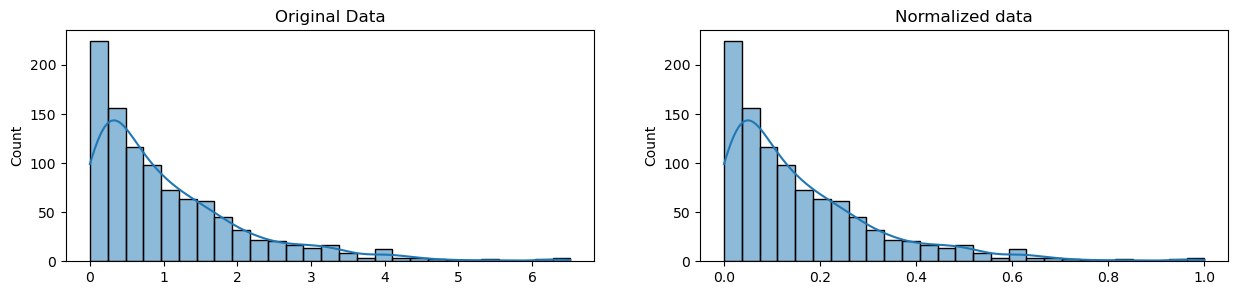

In [40]:
# generate 1000 data points randomly drawn from an exponential distribution
original_data = np.random.exponential(size=1000).reshape(-1, 1)

# fit scaler on data
norm = MinMaxScaler().fit(original_data)

# transform data
norm_data = norm.transform(original_data)

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(norm_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data")
plt.show()

Notice that data ranging from 0 to 6ish, they now range from 0 to 1.

### Standardization

Standardization is another Feature scaling method where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero, and the resultant distribution has a unit standard deviation.

Here’s the formula for standardization:

$$ Z = \frac{X - \text{Mean}}{\text{Standard Deviation}} $$

Let's take a quick peek at what normalizing some data looks like:

c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


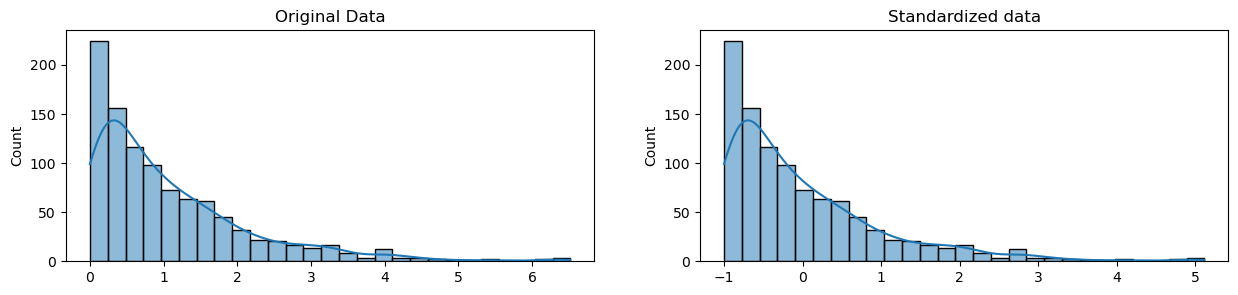

In [42]:
# fit on original data
stand = StandardScaler().fit(original_data)
    
# transform the original data
stand_data = stand.transform(original_data)

# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(stand_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Standardized data")
plt.show()

Notice that data ranging from 0 to 6ish, they now range from -1 to 5ish.

### The Big Question – Normalize or Standardize?
There are actually [many different scaling methods](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) available in scikit-learn. Let's read the conclusions from this excellent [Towards Data Science article](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf):
* Experiment with multiple scaling methods can dramatically increase your score on classification tasks, even when you hyperparameters are tuned. So, **you should consider the scaling method as an important hyperparameter of your model**.
* Scaling methods affect differently on different classifiers. Distance-based classifiers like SVM, KNN, and MLP (neural network) dramatically benefit from scaling. But even trees (CART, RF), that are agnostic to some of the scaling methods, can benefit from other methods.
* Knowing the underlying math behind models\preprocessing methods is the best way to understand the results. (For example, how trees work and why some of the scaling methods didn’t affect them). It can also save you a lot of time if you know no to apply StandardScaler when your model is Random Forest.
* Preprocessing methods like PCA that known to be benefited from scaling, do benefit from scaling. When it doesn’t, it might be due to a bad setup of the number of components parameter of PCA, outliers in the data or a bad choice of a scaling method.

#### ⚠ Attention! 
**The scalers must be fit only on the training data and then used to transform the testing data. This would avoid any data leakage during the model testing process.** Also, the scaling of target values is generally not required.

<a id='parsing'></a>
## 🧗 Parsing dates

### Load the data

The first thing we'll need to do is load in the libraries and dataset we'll be using. We'll be working with a dataset that contains information on landslides that occured between 2007 and 2016.

In [46]:
# read in our data
landslides = pd.read_csv("data/landslide-events.csv")

Now we're ready to look at some dates!

### Check the data type of our date column

We begin by taking a look at the first five rows of the data.

In [47]:
landslides.head()

,id,date,time,continent_code,country_name,country_code,state/province,population,city/town,distance,...,geolocation,hazard_type,landslide_type,landslide_size,trigger,storm_name,injuries,fatalities,source_name,source_link
0,34,3/2/07,Night,NaN,United States,US,Virginia,16000,Cherry Hill,3.40765,...,"(38.600900000000003, -77.268199999999993)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,NBC 4 news,http://www.nbc4.com/news/11186871/detail.html
1,42,3/22/07,NaN,NaN,United States,US,Ohio,17288,New Philadelphia,3.33522,...,"(40.517499999999998, -81.430499999999995)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,Canton Rep.com,http://www.cantonrep.com/index.php?ID=345054&C...
2,56,4/6/07,NaN,NaN,United States,US,Pennsylvania,15930,Wilkinsburg,2.91977,...,"(40.4377, -79.915999999999997)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,The Pittsburgh Channel.com,https://web.archive.org/web/20080423132842/htt...
3,59,4/14/07,NaN,NaN,Canada,CA,Quebec,42786,Châteauguay,2.98682,...,"(45.322600000000001, -73.777100000000004)",Landslide,Riverbank collapse,Small,Rain,NaN,NaN,NaN,Le Soleil,http://www.hebdos.net/lsc/edition162007/articl...
4,61,4/15/07,NaN,NaN,United States,US,Kentucky,6903,Pikeville,5.66542,...,"(37.432499999999997, -82.493099999999998)",Landslide,Landslide,Small,Downpour,NaN,NaN,0.0,Matthew Crawford (KGS),NaN


We'll be working with the "date" column from the `landslides` dataframe. Let's make sure it actually looks like it contains dates.

In [48]:
# print the first few rows of the date column
print(landslides['date'].head())

0     3/2/07
1    3/22/07
2     4/6/07
3    4/14/07
4    4/15/07
Name: date, dtype: object


Yep, those are dates! But just because I, a human, can tell that these are dates doesn't mean that Python knows that they're dates. Notice that at the bottom of the output of `head()`, you can see that it says that the data type of this  column is "object". 

> Pandas uses the "object" dtype for storing various types of data types, but most often when you see a column with the dtype "object" it will have strings in it. 

If you check the pandas dtype documentation [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#dtypes), you'll notice that there's also a specific `datetime64` dtypes. Because the dtype of our column is `object` rather than `datetime64`, we can tell that Python doesn't know that this column contains dates.

We can also look at just the dtype of a column without printing the first few rows:

In [49]:
# check the data type of our date column
landslides['date'].dtype

dtype('O')

You may have to check the [numpy documentation](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.dtype.kind.html#numpy.dtype.kind) to match the letter code to the dtype of the object. "O" is the code for "object", so we can see that these two methods give us the same information.

### Convert our date columns to datetime

Now that we know that our date column isn't being recognized as a date, it's time to convert it so that it *is* recognized as a date. This is called "parsing dates" because we're taking in a string and identifying its component parts.

We can determine what the format of our dates are with a guide called ["strftime directive", which you can find more information on at this link](http://strftime.org/). The basic idea is that you need to point out which parts of the date are where and what punctuation is between them. There are [lots of possible parts of a date](http://strftime.org/), but the most common are `%d` for day, `%m` for month, `%y` for a two-digit year and `%Y` for a four digit year.

Some examples:

 * 1/17/07 has the format "%m/%d/%y"
 * 17-1-2007 has the format "%d-%m-%Y"
 
Looking back up at the head of the "date" column in the landslides dataset, we can see that it's in the format "month/day/two-digit year", so we can use the same syntax as the first example to parse in our dates: 

In [50]:
# create a new column, date_parsed, with the parsed dates
landslides['date_parsed'] = pd.to_datetime(landslides['date'], format="%m/%d/%y")

Now when I check the first few rows of the new column, I can see that the dtype is `datetime64`. I can also see that my dates have been slightly rearranged so that they fit the default order datetime objects (year-month-day).

In [51]:
# print the first few rows
landslides['date_parsed'].head()

0   2007-03-02
1   2007-03-22
2   2007-04-06
3   2007-04-14
4   2007-04-15
Name: date_parsed, dtype: datetime64[ns]

Now that our dates are parsed correctly, we can interact with them in useful ways.

___
* **What if I run into an error with multiple date formats?** While we're specifying the date format here, sometimes you'll run into an error when there are multiple date formats in a single column. If that happens, you can have pandas try to infer what the right date format should be. You can do that like so:

`landslides['date_parsed'] = pd.to_datetime(landslides['Date'], infer_datetime_format=True)`

* **Why don't you always use `infer_datetime_format = True?`** There are two big reasons not to always have pandas guess the time format. The first is that pandas won't always been able to figure out the correct date format, especially if someone has gotten creative with data entry. The second is that it's much slower than specifying the exact format of the dates.

### Select the day of the month

Now that we have a column of parsed dates, we can extract information like the day of the month that a landslide occurred.

In [52]:
# get the day of the month from the date_parsed column
day_of_month_landslides = landslides['date_parsed'].dt.day
day_of_month_landslides.head()

0     2.0
1    22.0
2     6.0
3    14.0
4    15.0
Name: date_parsed, dtype: float64

If we tried to get the same information from the original "date" column, we would get an error: `AttributeError: Can only use .dt accessor with datetimelike values`.  This is because `dt.day` doesn't know how to deal with a column with the dtype "object". Even though our dataframe has dates in it, we have to parse them before we can interact with them in a useful way.

### Plot the day of the month to check the date parsing

One of the biggest dangers in parsing dates is mixing up the months and days. The `to_datetime()` function does have very helpful error messages, but it doesn't hurt to double-check that the days of the month we've extracted make sense. 

To do this, let's plot a histogram of the days of the month. We expect it to have values between 1 and 31 and, since there's no reason to suppose the landslides are more common on some days of the month than others, a relatively even distribution. (With a dip on 31 because not all months have 31 days.) Let's see if that's the case:

c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


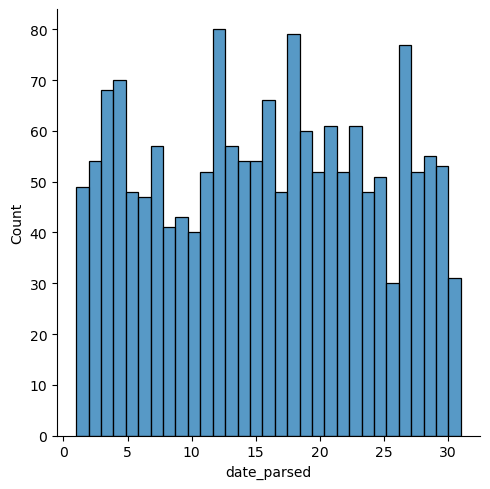

In [53]:
# remove na's
day_of_month_landslides = day_of_month_landslides.dropna()

# plot the day of the month
sns.displot(day_of_month_landslides, kind='hist', bins=31)

Yep, it looks like we did parse our dates correctly and this graph makes good sense to me.

<a id='inconsistent_data_entry'></a>
## 🧗 Inconsistent data entry

In [54]:
# read in all our data
professors = pd.read_csv("data/pakistan_intellectual_capital.csv")

### Do some preliminary text pre-processing

We'll begin by taking a quick look at the first few rows of the data.

In [55]:
professors.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


Say we're interested in cleaning up the "Country" column to make sure there's no data entry inconsistencies in it. We could go through and check each row by hand, of course, and hand-correct inconsistencies when we find them. There's a more efficient way to do this, though!

In [56]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array([' Germany', ' New Zealand', ' Sweden', ' USA', 'Australia',
       'Austria', 'Canada', 'China', 'Finland', 'France', 'Greece',
       'HongKong', 'Ireland', 'Italy', 'Japan', 'Macau', 'Malaysia',
       'Mauritius', 'Netherland', 'New Zealand', 'Norway', 'Pakistan',
       'Portugal', 'Russian Federation', 'Saudi Arabia', 'Scotland',
       'Singapore', 'South Korea', 'SouthKorea', 'Spain', 'Sweden',
       'Thailand', 'Turkey', 'UK', 'USA', 'USofA', 'Urbana', 'germany'],
      dtype=object)

Just looking at this, I can see some problems due to inconsistent data entry: ' Germany', and 'germany', for example, or ' New Zealand' and 'New Zealand'.

The first thing I'm going to do is make everything lower case (I can change it back at the end if I like) and remove any white spaces at the beginning and end of cells. Inconsistencies in capitalizations and trailing white spaces are very common in text data and you can fix a good 80% of your text data entry inconsistencies by doing this.

In [57]:
# convert to lower case
professors['Country'] = professors['Country'].str.lower()
# remove trailing white spaces
professors['Country'] = professors['Country'].str.strip()

Next we're going to tackle more difficult inconsistencies.

### Use fuzzy matching to correct inconsistent data entry

Alright, let's take another look at the 'Country' column and see if there's any more data cleaning we need to do.

In [58]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea',
       'southkorea', 'spain', 'sweden', 'thailand', 'turkey', 'uk',
       'urbana', 'usa', 'usofa'], dtype=object)

It does look like there is another inconsistency: 'southkorea' and 'south korea' should be the same. 

We're going to use the [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy) package to help identify which strings are closest to each other. This dataset is small enough that we could probably could correct errors by hand, but that approach doesn't scale well. (Would you want to correct a thousand errors by hand? What about ten thousand? Automating things as early as possible is generally a good idea. Plus, it’s fun!)

> **Fuzzy matching:** The process of automatically finding text strings that are very similar to the target string. In general, a string is considered "closer" to another one the fewer characters you'd need to change if you were transforming one string into another. So "apple" and "snapple" are two changes away from each other (add "s" and "n") while "in" and "on" and one change away (rplace "i" with "o"). You won't always be able to rely on fuzzy matching 100%, but it will usually end up saving you at least a little time.

Fuzzywuzzy returns a ratio given two strings. The closer the ratio is to 100, the smaller the edit distance between the two strings. Here, we're going to get the ten strings from our list of countries that have the closest distance to "south korea".

In [59]:
# get the top 10 closest matches to "south korea"
matches = fuzzywuzzy.process.extract("south korea", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('south korea', 100),
 ('southkorea', 48),
 ('saudi arabia', 43),
 ('norway', 35),
 ('ireland', 33),
 ('portugal', 32),
 ('singapore', 30),
 ('netherland', 29),
 ('macau', 25),
 ('usofa', 25)]

We can see that two of the items in the countries are very close to "south korea": "south korea" and "southkorea". Let's replace all rows in our "Country" column that have a ratio of > 47 with "south korea". 

To do this, I'm going to write a function. (It's a good idea to write a general purpose function you can reuse if you think you might have to do a specific task more than once or twice. This keeps you from having to copy and paste code too often, which saves time and can help prevent mistakes.)

In [60]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")

Now that we have a function, we can put it to the test!

In [61]:
# use the function we just wrote to replace close matches to "south korea" with "south korea"
replace_matches_in_column(df=professors, column='Country', string_to_match="south korea")

All done!


And now let's check the unique values in our "Country" column again and make sure we've tidied up "south korea" correctly.

In [62]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea', 'spain',
       'sweden', 'thailand', 'turkey', 'uk', 'urbana', 'usa', 'usofa'],
      dtype=object)

Excellent! Now we only have "south korea" in our dataframe and we didn't have to change anything by hand. 